In [1]:
# 测试模型
# 1.从权重中加载
# 2.对test_dataset做测试，GD和prediction分别显示出来，以作对比
# 3.生成动画
# 4.对imagesTs下的文件也测试一下（从未见过）

In [2]:
import torch

C:\conda\envs\unet_seg\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 定义两次卷积操作
class ConvBlock(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        
        self.step = torch.nn.Sequential(
            # 第一次卷积
            torch.nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=1),
            # ReLU
            torch.nn.ReLU(),
            # 第二次卷积
            torch.nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=1),
            # ReLU
            torch.nn.ReLU()
        )
    
    def forward(self,x):
        
        return self.step(x)
    

In [4]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 定义左侧编码器的操作
        self.layer1 = ConvBlock(1,64)
        self.layer2 = ConvBlock(64,128)
        self.layer3 = ConvBlock(128,256)
        self.layer4 = ConvBlock(256,512)
        
        # 定义右侧解码器的操作
        self.layer5 = ConvBlock(256+512,256)
        self.layer6 = ConvBlock(128+256,128)
        self.layer7 = ConvBlock(64+128,64)
        
        #最后一个卷积
        self.layer8  = torch.nn.Conv2d(in_channels=64,out_channels=1,kernel_size=1,padding=0,stride=1)
        
        # 定一些其他操作
        # 池化
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)
        #上采样
        self.upsample = torch.nn.Upsample(scale_factor=2,mode='bilinear')
        # sigmoid
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self,x):
        # 对输入数据进行处理
        
        # 定义下采样部分
        
        # input:1X256x256, output: 64x256x256
        x1 = self.layer1(x)
        # input:64x256x256, output: 64 x 128 x 128
        x1_p = self.maxpool(x1)
        
        # input:  64 x 128 x 128 , output: 128 x 128 x 128
        x2 = self.layer2(x1_p)
        # input:128 x 128 x 128 , output: 128 x 64 x 64
        x2_p = self.maxpool(x2)
        
        # input: 128 x 64 x 64, output: 256 x 64 x 64
        x3 = self.layer3(x2_p)
        #input:256 x 64 x 64, output: 256 x 32 x 32
        x3_p = self.maxpool(x3)
        
        #input: 256 x 32 x 32, output: 512 x 32 x 32
        x4 = self.layer4(x3_p)
        
        
        
        # 定义上采样
        # input: 512 x 32 x 32，output: 512 x 64 x 64
        x5 = self.upsample(x4)
        # 拼接,output: 768x 64 x 64
        x5 = torch.cat([x5,x3],dim=1)
        # input: 768x 64 x 64,output: 256 x 64 x 64
        x5 = self.layer5(x5)
        
        # input: 256 x 64 x 64,output: 256 x 128 x 128
        x6  = self.upsample(x5)
        # 拼接,output: 384 x 128 x 128
        x6 = torch.cat([x6,x2],dim=1)
        # input: 384 x 128 x 128, output: 128 x 128 x 128
        x6 = self.layer6(x6)
        
        
        # input:128 x 128 x 128, output: 128 x 256 x 256
        x7 = self.upsample(x6)
        # 拼接, output: 192 x 256 x256
        x7 = torch.cat([x7,x1],dim=1)
        # input: 192 x 256 x256, output: 64 x 256 x 256
        x7 = self.layer7(x7)
        
        # 最后一次卷积,input: 64 x 256 x 256, output: 1 x 256 x 256
        x8 = self.layer8(x7)
        
        #sigmoid
        x9= self.sigmoid(x8)
        
        
        
        return x9
        
        
        

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
model = UNet().to(device)

In [7]:
# 从权重中恢复

In [8]:
model.load_state_dict(torch.load('saved_model/unet_best.pt'))

<All keys matched successfully>

In [9]:
model.eval()

UNet(
  (layer1): ConvBlock(
    (step): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (layer2): ConvBlock(
    (step): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (layer3): ConvBlock(
    (step): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (layer4): ConvBlock(
    (step): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )


In [10]:
# 用来推理

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import glob
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from natsort import natsorted 

In [12]:
class SegmentDataset(Dataset):

    def __init__(self,where='train',seq=None):
        # 获取数据
        self.img_list =natsorted( glob.glob('processed/{}/*/img_*'.format(where)))
        self.mask_list = natsorted( glob.glob('processed/{}/*/img_*') )
        # 数据增强pipeline
        self.seq = seq

    def __len__(self):
        # 返回数据大小
        return len(self.img_list)
    

    def __getitem__(self, idx):
        # 获取具体每一个数据
        
        # 获取图片
        img_file = self.img_list[idx]
        mask_file = img_file.replace('img','label')
        img = np.load(img_file)
        # 获取mask
        mask = np.load(mask_file)
        
        # 如果需要数据增强
        if self.seq:
            segmap = SegmentationMapsOnImage(mask, shape=mask.shape)
            img,mask = seq(image=img, segmentation_maps=segmap)
            # 直接获取数组内容
            mask =  mask.get_arr()
        
        # 灰度图扩张维度成张量
        return np.expand_dims(img,0) , np.expand_dims(mask,0)
        

In [13]:
# 使用dataloader加载
batch_size = 12
num_workers = 0

test_dataset = SegmentDataset('test',None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [14]:
len(test_dataset)

339

In [15]:
import tqdm
from celluloid import Camera
from IPython.display import HTML

  0%|                                                                                          | 0/339 [00:00<?, ?it/s]C:\conda\envs\unet_seg\lib\site-packages\torch\nn\functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 339/339 [00:12<00:00, 28.12it/s]


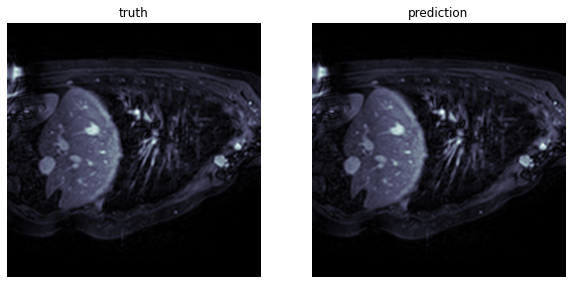

In [16]:
# 将每层画面制作成视频
fig = plt.figure(figsize=(10, 10))
camera = Camera(fig)
# 遍历所有数据
for x, y in tqdm.tqdm(test_dataset):
    
    # 输出输入
    input = torch.tensor([x]).to(device,dtype=torch.float32)
    # 推理
    y_pred = model(input)
    # 获取mask
    mask_data = (y_pred.detach().cpu().numpy()[0][0] > 0.5)
    
    plt.subplot(1, 2, 1)
    plt.imshow(x[0], cmap='bone')
    mask_ = np.ma.masked_where(y[0] == 0, y[0])
    plt.imshow(mask_, alpha=0.8, cmap="spring")
    plt.title('truth')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(x[0], cmap='bone')
    mask_ = np.ma.masked_where(mask_data == 0, mask_data)
    plt.imshow(mask_, alpha=0.8, cmap="spring")
    plt.title('prediction')
    plt.axis('off')
    
    camera.snap()

animation = camera.animate()


In [17]:
HTML(animation.to_html5_video())  # convert the animation to a video


In [18]:
# 测试未知图片
import glob
import os
import nibabel as nib

In [19]:
test_file_list = glob.glob('data/imagesTs/la*')

In [20]:
# 和模型训练一样的预处理

In [21]:
# 标准化
def standardize(data):
    # 计算均值
    mean = data.mean()
    # 计算标准差
    std = np.std(data)
    # 计算结果
    standardized = (data - mean) / std
    return standardized
# 归一化
def normalize(data):
    # 计算最大最小值
    max_val = data.max()
    min_val = data.min()
    normalized = (data - min_val) / (max_val - min_val)
    return normalized

In [22]:
# 挑选一个文件测试
# 读取文件
# 裁剪边缘
# 标准化和归一化
file = test_file_list[1]
# 读取
img = nib.load(file)
img_data = img.get_fdata()
    
# 裁剪边缘
img_data_crop = img_data[32:-32,32:-32]

# 标准化和归一化
std = standardize(img_data_crop)
normalized = normalize(std)

In [23]:
# 查看层数
img_data_crop.shape

(256, 256, 140)

  0%|                                                                                          | 0/140 [00:00<?, ?it/s]C:\conda\envs\unet_seg\lib\site-packages\torch\nn\functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:04<00:00, 32.99it/s]


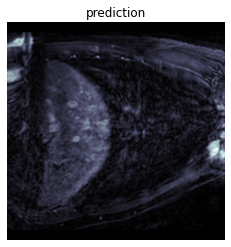

In [24]:
# 将每层画面制作成视频
fig = plt.figure()
camera = Camera(fig)
layer_num = normalized.shape[-1]
for i in tqdm.tqdm(range(layer_num)):
    # 获取该层图像
    layer = normalized[:,:,i]
    # 输出输入
    input = torch.tensor([[layer]]).to(device,dtype=torch.float32)
    # 推理
    y_pred = model(input)
    # 获取mask
    mask_data = (y_pred.detach().cpu().numpy()[0][0] > 0.5)
    
    plt.imshow(layer, cmap='bone')
    mask_ = np.ma.masked_where(mask_data == 0, mask_data)
    plt.imshow(mask_, alpha=0.8, cmap="spring")
    plt.title('prediction')
    plt.axis('off')
    
    camera.snap()

animation = camera.animate()


In [25]:
HTML(animation.to_html5_video())  # convert the animation to a video
